#Image Caption -> ResNet, TransformerDecoder


https://www.kaggle.com/dipanjandas96/image-caption-resnet-transformerdecoder-pytorch

1. Creating features for Images Using Resnet

2. Train Trnasformer Decoder Model which predicts next word given a sequence of tockens and Image Features from Step1

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import torchvision
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.autograd import Variable
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F
import pickle
import gc
import random

pd.set_option('display.max_colwidth', None)

In [3]:
# read data
# "/content/gdrive/MyDrive/Colab Notebooks/Folk Painting Source Data/archive/Images"
# "/content/gdrive/MyDrive/Colab Notebooks/Folk Painting Source Data/archive/captions.txt",

df=pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Folk Painting Source Data/archive/captions.txt', sep=',')
print(len(df))
display(df.head(3)) # 데이터가 제대로 읽어와졌는지 확인하기 위해, 상위 3개 caption 출력.


40455


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .


#데이터 전처리
Single Character(단일 문자), non alpha word 제거, 토큰과 ',' 추가.
모든 캡션의 최대 길이(max_seq_len)는 33으로 맞춰진다.


In [4]:
def remove_single_char_word(word_list):
  lst=[]
  for word in word_list:
    if len(word)>1:
      lst.append(word)
  return lst

In [5]:
# <start> < > < > ... < > <end> 형태로 캡션 저장 => 최대 길이: 33
df['cleaned_caption']=df['caption'].apply(lambda caption : ['<start>']+[word.lower() if word.isalpha() else '' for word in caption.split(" ")]+['<end>'])

# single character 제거
df['cleaned_caption']=df['cleaned_caption'].apply(lambda x:remove_single_char_word(x))

# seq_len에 길이 저장 => 33
df['seq_len']=df['cleaned_caption'].apply(lambda x:len(x))
max_seq_len=df['seq_len'].max()
print(max_seq_len)

33


In [6]:
df.drop(['seq_len'], axis = 1, inplace=True)
df['cleaned_caption']=df['cleaned_caption'].apply(lambda caption: caption+['<pad>']*(max_seq_len-len(caption)))

# 상위 3개 데이터 예시 출력
display(df.head(3))

,image,caption,cleaned_caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .,"[<start>, child, in, pink, dress, is, climbing, up, set, of, stairs, in, an, entry, way, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[<start>, girl, going, into, wooden, building, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,"[<start>, little, girl, climbing, into, wooden, playhouse, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"


# Create Vocab and mapping of token to ID

In [7]:
word_list=df['cleaned_caption'].apply(lambda x: " ".join(x)).str.cat(sep=' ').split(' ')  
#join: , cat(concat): 문자열 합치기. sep=' '에 의해 한 칸씩 뛰고 저장이 된다.
word_dict=Counter(word_list)
word_dict=sorted(word_dict, key=word_dict.get, reverse=True)

print(len(word_dict))
print(word_dict[:20])

8360
['<pad>', '<start>', '<end>', 'in', 'the', 'on', 'is', 'and', 'dog', 'with', 'man', 'of', 'two', 'white', 'black', 'boy', 'are', 'woman', 'girl', 'to']


In [8]:
vocab_size=len(word_dict)
print(vocab_size)

index_to_word = {index: word for index, word in enumerate(word_dict)} #enumerate: 반복문에서 index값(몇번째 요소인지)을 출력
word_to_index = {word: index for index, word in enumerate(word_dict)}
print(len(index_to_word), len(word_to_index))

8360
8360 8360


# Convert sequence of tokens to IDs

text_seq를 부여함. 단어별로 ID를 부여함.

In [9]:
df['text_seq']=df['cleaned_caption'].apply(lambda caption: [word_to_index[word] for word in caption])
display(df.head(3))

,image,caption,cleaned_caption,text_seq
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .,"[<start>, child, in, pink, dress, is, climbing, up, set, of, stairs, in, an, entry, way, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 41, 3, 89, 168, 6, 118, 52, 392, 11, 389, 3, 27, 5075, 690, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[<start>, girl, going, into, wooden, building, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 18, 311, 63, 192, 116, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,"[<start>, little, girl, climbing, into, wooden, playhouse, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 39, 18, 118, 63, 192, 2402, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


# Split in Train and validation data. 
(Train과 validation data 나누기) 
한 데이터가 동시에 training, validation data가 될 수 없음.

In [10]:
df=df.sort_values(by='image')
train=df.iloc[:int(0.9*len(df))]  # train과 validation의 비율은 9:1
valid=df.iloc[int(0.9*len(df)):]

print(len(train), train['image'].nunique()) #nunique() : 데이터에 고유값들의 수를 출력, 즉 중복되는 않은 순 단어의 개수 세기
print(len(valid), valid['image'].nunique())

36409 7282
4046 810


# Extract features from Images Using Resnet
Restnet 구조를 통해 feature 추출

In [11]:
train_samples=len(train)
print(train_samples)  # train 길이 출력

unq_train_imgs=train[['image']].drop_duplicates() #중복되는 이미지 제거
unq_valid_imgs = valid[['image']].drop_duplicates()
print(len(unq_train_imgs), len(unq_valid_imgs))

36409
7282 810


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device) #Cuda 사용

cuda


In [26]:
class extractImageFeatureResNetDataSet(): # Resnet 구조를 이용해 이미지의 feature 값들을 추출
  def __init__(self, data):
    self.data=data
    self.scaler=transforms.Resize([224, 224]) # 이미지 크기 재정의
    self.normalize=transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    self.to_tensor=transforms.ToTensor()

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    image_name=self.data.iloc[idx]['image']
    img_loc="/content/gdrive/MyDrive/Colab Notebooks/Folk Painting Source Data/archive/Images/" + str(image_name)
    img=Image.open(img_loc)
    t_img=self.normalize(self.to_tensor(self.scaler(img)))
    return image_name, t_img

In [14]:
from torchvision import transforms

In [27]:
train_ImageDataset_ResNet = extractImageFeatureResNetDataSet(unq_train_imgs)  # train 이미지들의 feature를 추출해 저장
train_ImageDataloader_ResNet = DataLoader(train_ImageDataset_ResNet, batch_size=1, shuffle=False)

valid_ImageDataset_ResNet = extractImageFeatureResNetDataSet(unq_valid_imgs)  # validation 이미지들의 feature를 추출해 저장
valid_ImageDataloader_ResNet = DataLoader(valid_ImageDataset_ResNet, batch_size = 1, shuffle=False)

In [28]:
resnet18 = torchvision.models.resnet18(pretrained=True).to(device)
resnet18.eval()
list(resnet18._modules)

['conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool',
 'fc']

In [44]:
resNet18Layer4 = resnet18._modules.get('layer4').to(device)

In [45]:
def get_vector(t_img):
  t_img = Variable(t_img)
  my_embedding = torch.zeros(1, 512, 7, 7)  # torch.zeros : 0으로 채워진 텐서 생성
  def copy_data(m, i, o):
    my_embedding.copy_(o.data)

  h = resNet18Layer4.register_forward_hook(copy_data)
  resnet18(t_img)

  h.remove()
  return my_embedding

In [22]:
# print("/content/gdrive/MyDrive/Colab Notebooks/Folk Painting Source Data/archive/Images/1000268201_693b08cb0e.jpg")

/content/gdrive/MyDrive/Colab Notebooks/Folk Painting Source Data/archive/Images/1000268201_693b08cb0e.jpg


In [46]:
extract_imgFtr_ResNet_train = {}  # train 이미지들의 feature 추출
for image_name, t_img in tqdm(train_ImageDataloader_ResNet):   # tqdm: 진행률 프로그래스바
  t_img = t_img.to(device)
  embdg = get_vector(t_img)

  extract_imgFtr_ResNet_train[image_name[0]] = embdg

  0%|          | 0/7282 [00:00<?, ?it/s]

In [47]:
a_file = open("./EncodedImageTrainResNet.pkl", "wb")
pickle.dump(extract_imgFtr_ResNet_train, a_file)
a_file.close()

In [48]:
extract_imgFtr_ResNet_valid = {}
for image_name, t_img in tqdm(valid_ImageDataloader_ResNet):
  t_img = t_img.to(device)
  embdg = get_vector(t_img)
  extract_imgFtr_ResNet_valid[image_name[0]] = embdg

  0%|          | 0/810 [00:00<?, ?it/s]

In [49]:
a_file=open("./EncodedImageValidResNet.pkl", "wb")
pickle.dump(extract_imgFtr_ResNet_valid, a_file)
a_file.close()

#Create DataLoader which will be used to load data into Transformer Model
Transformer 모델에 데이터를 load하는데 사용할 dataloader을 생성

(FlickerDataSetResnet will return caption sequence, 1 timestep left shifted caption sequence which model will predict and Stored Image features from ResNet.)

In [68]:
global image_tensor_view

class FlickerDataSetResnet():
  def __init__(self, data, pkl_file):
    self.data=data
    self.encodedImgs = pd.read_pickle(pkl_file)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    caption_seq = self.data.iloc[idx]['text_seq']
    target_seq = caption_seq[1:]+[0]

    image_name = self.data.iloc[idx]['image']
    image_tensor = self.encodedImgs[image_name]
    image_tensor = image_tensor.permute(0,2,3,1)  # tensor의 모양을 변환. permute는 모든 차원을 교환할 수 있음.
    image_tensor_view = image_tensor.view(image_tensor.size(0), -1, image_tensor.size(3))
    return torch.tensor(caption_seq), torch.tensor(target_seq), image_tensor_view

In [69]:
train_dataset_resnet = FlickerDataSetResnet(train, 'EncodedImageTrainResNet.pkl')
train_dataloader_resnet = DataLoader(train_dataset_resnet, batch_size = 32, shuffle=True)

In [70]:
valid_dataset_resnet = FlickerDataSetResnet(valid, 'EncodedImageValidResNet.pkl')
valid_dataloader_resnet = DataLoader(valid_dataset_resnet, batch_size = 32, shuffle = True)

#Create Transformer Decoder Model
This model will take caption sequence and the extracted resnet image features as input and output 1 timestep shifted caption sequence.

In the Transformer decoder, lookAhead and padding mask has also been applied

In [71]:
# Position Embedding

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=max_seq_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        

    def forward(self, x):
        if self.pe.size(0) < x.size(0):
            self.pe = self.pe.repeat(x.size(0), 1, 1).to(device)
        self.pe = self.pe[:x.size(0), : , : ]
        
        x = x + self.pe
        return self.dropout(x)

In [72]:
# Image Captioning Model
# Transformer Decoder

class ImageCaptionModel(nn.Module):
    def __init__(self, n_head, n_decoder_layer, vocab_size, embedding_size):
        super(ImageCaptionModel, self).__init__()
        self.pos_encoder = PositionalEncoding(embedding_size, 0.1)
        self.TransformerDecoderLayer = nn.TransformerDecoderLayer(d_model =  embedding_size, nhead = n_head)
        self.TransformerDecoder = nn.TransformerDecoder(decoder_layer = self.TransformerDecoderLayer, num_layers = n_decoder_layer)
        self.embedding_size = embedding_size
        self.embedding = nn.Embedding(vocab_size , embedding_size)
        self.last_linear_layer = nn.Linear(embedding_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.last_linear_layer.bias.data.zero_()
        self.last_linear_layer.weight.data.uniform_(-initrange, initrange)

    def generate_Mask(self, size, decoder_inp):
        decoder_input_mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        decoder_input_mask = decoder_input_mask.float().masked_fill(decoder_input_mask == 0, float('-inf')).masked_fill(decoder_input_mask == 1, float(0.0))

        decoder_input_pad_mask = decoder_inp.float().masked_fill(decoder_inp == 0, float(0.0)).masked_fill(decoder_inp > 0, float(1.0))
        decoder_input_pad_mask_bool = decoder_inp == 0

        return decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool

    def forward(self, encoded_image, decoder_inp):
        encoded_image = encoded_image.permute(1,0,2)
        

        decoder_inp_embed = self.embedding(decoder_inp)* math.sqrt(self.embedding_size)
        
        decoder_inp_embed = self.pos_encoder(decoder_inp_embed)
        decoder_inp_embed = decoder_inp_embed.permute(1,0,2)
        

        decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool = self.generate_Mask(decoder_inp.size(1), decoder_inp)
        decoder_input_mask = decoder_input_mask.to(device)
        decoder_input_pad_mask = decoder_input_pad_mask.to(device)
        decoder_input_pad_mask_bool = decoder_input_pad_mask_bool.to(device)
        

        decoder_output = self.TransformerDecoder(tgt = decoder_inp_embed, memory = encoded_image, tgt_mask = decoder_input_mask, tgt_key_padding_mask = decoder_input_pad_mask_bool)
        
        final_output = self.last_linear_layer(decoder_output)

        return final_output,  decoder_input_pad_mask

#Train the Model

The cross entropy loss has been masked at time steps where input token is <'pad'>.

In [73]:
EPOCH = 30

In [74]:
ictModel = ImageCaptionModel(16, 4, vocab_size, 512).to(device)
optimizer = torch.optim.Adam(ictModel.parameters(), lr = 0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience=2, verbose=True)
criterion=torch.nn.CrossEntropyLoss(reduction='none')
min_val_loss=np.float('Inf')

In [75]:
for epoch in tqdm(range(EPOCH)):
    total_epoch_train_loss = 0
    total_epoch_valid_loss = 0
    total_train_words = 0
    total_valid_words = 0
    ictModel.train()

    ### Train Loop
    for caption_seq, target_seq, image_embed in train_dataloader_resnet:
        optimizer.zero_grad()

        image_embed = image_embed.squeeze(1).to(device)
        caption_seq = caption_seq.to(device)
        target_seq = target_seq.to(device)

        output, padding_mask = ictModel.forward(image_embed, caption_seq)
        output = output.permute(1, 2, 0)

        loss = criterion(output,target_seq)

        loss_masked = torch.mul(loss, padding_mask)

        final_batch_loss = torch.sum(loss_masked)/torch.sum(padding_mask)

        final_batch_loss.backward()
        optimizer.step()
        total_epoch_train_loss += torch.sum(loss_masked).detach().item()
        total_train_words += torch.sum(padding_mask)

 
    total_epoch_train_loss = total_epoch_train_loss/total_train_words
  

    ### Eval Loop
    ictModel.eval()
    with torch.no_grad():
        for caption_seq, target_seq, image_embed in valid_dataloader_resnet:

            image_embed = image_embed.squeeze(1).to(device)
            caption_seq = caption_seq.to(device)
            target_seq = target_seq.to(device)

            output, padding_mask = ictModel.forward(image_embed, caption_seq)
            output = output.permute(1, 2, 0)

            loss = criterion(output,target_seq)

            loss_masked = torch.mul(loss, padding_mask)

            total_epoch_valid_loss += torch.sum(loss_masked).detach().item()
            total_valid_words += torch.sum(padding_mask)

    total_epoch_valid_loss = total_epoch_valid_loss/total_valid_words
  
    print("Epoch -> ", epoch," Training Loss -> ", total_epoch_train_loss.item(), "Eval Loss -> ", total_epoch_valid_loss.item() )
  
    if min_val_loss > total_epoch_valid_loss:
        print("Writing Model at epoch ", epoch)
        torch.save(ictModel, './BestModel')
        min_val_loss = total_epoch_valid_loss
  

    scheduler.step(total_epoch_valid_loss.item())

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch ->  0  Training Loss ->  5.325611591339111 Eval Loss ->  4.395051002502441
Writing Model at epoch  0
Epoch ->  1  Training Loss ->  4.240620136260986 Eval Loss ->  4.005524635314941
Writing Model at epoch  1
Epoch ->  2  Training Loss ->  3.9281134605407715 Eval Loss ->  3.8127949237823486
Writing Model at epoch  2
Epoch ->  3  Training Loss ->  3.7332186698913574 Eval Loss ->  3.680007219314575
Writing Model at epoch  3
Epoch ->  4  Training Loss ->  3.5871450901031494 Eval Loss ->  3.589986801147461
Writing Model at epoch  4
Epoch ->  5  Training Loss ->  3.4715447425842285 Eval Loss ->  3.5204317569732666
Writing Model at epoch  5
Epoch ->  6  Training Loss ->  3.374809741973877 Eval Loss ->  3.462522268295288
Writing Model at epoch  6
Epoch ->  7  Training Loss ->  3.2883567810058594 Eval Loss ->  3.4217729568481445
Writing Model at epoch  7
Epoch ->  8  Training Loss ->  3.2136335372924805 Eval Loss ->  3.3841381072998047
Writing Model at epoch  8
Epoch ->  9  Training Loss 

#Generate Captions

In [76]:
model = torch.load('./BestModel')
start_token = word_to_index['<start>']
end_token = word_to_index['<end>']
pad_token = word_to_index['<pad>']
max_seq_len = 33
print(start_token, end_token, pad_token)

1 2 0


In [77]:
valid_img_embed = pd.read_pickle('EncodedImageValidResNet.pkl')

In [103]:
def generate_caption(K, img_nm): 
    img_loc = '/content/gdrive/MyDrive/Colab Notebooks/Folk Painting Source Data/archive/Images/'+str(img_nm)
    image = Image.open(img_loc).convert("RGB")
    plt.imshow(image)

    model.eval() 
    valid_img_df = valid[valid['image']==img_nm]
    print("Actual Caption : ")
    print(valid_img_df['caption'].tolist())
    img_embed = valid_img_embed[img_nm].to(device)


    img_embed = img_embed.permute(0,2,3,1)
    img_embed = img_embed.view(img_embed.size(0), -1, img_embed.size(3))


    input_seq = [pad_token]*max_seq_len
    input_seq[0] = start_token

    input_seq = torch.tensor(input_seq).unsqueeze(0).to(device)
    predicted_sentence = []
    with torch.no_grad():
        for eval_iter in range(0, max_seq_len):

            output, padding_mask = model.forward(img_embed, input_seq)

            output = output[eval_iter, 0, :]

            values = torch.topk(output, K).values.tolist()
            indices = torch.topk(output, K).indices.tolist()

            next_word_index = random.choices(indices, values, k = 1)[0]

            next_word = index_to_word[next_word_index]

            input_seq[:, eval_iter+1] = next_word_index


            if next_word == '<end>' :
                break

            predicted_sentence.append(next_word)
    print("\n")
    print("Predicted caption : ")
    print(" ".join(predicted_sentence+['.']))

Actual Caption : 
['Young child in pink top and purple pants clutching a turquoise guard rail .', 'A very young girl is walking on a playground .', 'The little girl is playing at the playground .', 'A little girl in pink and purple stands on a playground .', 'A female toddler wearing a pink shirt is playing on a playground .']


Predicted caption : 
little girl in pink shirt and jeans is jumping on playground playground .


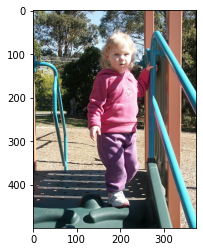

In [104]:
generate_caption(1, unq_valid_imgs.iloc[50]['image'])

Actual Caption : 
['Young child in pink top and purple pants clutching a turquoise guard rail .', 'A very young girl is walking on a playground .', 'The little girl is playing at the playground .', 'A little girl in pink and purple stands on a playground .', 'A female toddler wearing a pink shirt is playing on a playground .']


Predicted caption : 
young child in blue shirt and jeans is standing in front of playground slide on playground .


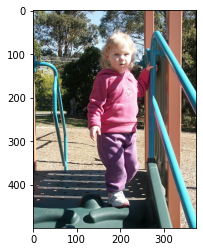

In [105]:
generate_caption(2, unq_valid_imgs.iloc[50]['image'])

Actual Caption : 
['Young child in pink top and purple pants clutching a turquoise guard rail .', 'A very young girl is walking on a playground .', 'The little girl is playing at the playground .', 'A little girl in pink and purple stands on a playground .', 'A female toddler wearing a pink shirt is playing on a playground .']


Predicted caption : 
little kid in pink top and blue pants is standing on slide and playground slide .


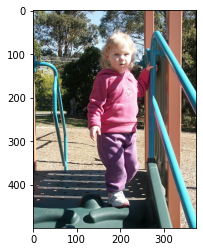

In [106]:
generate_caption(3, unq_valid_imgs.iloc[50]['image'])

Actual Caption : 
['A caravan of snowmobile travel through the snow .', 'A pair of people in heavy winter jackets rides through the snow on a snowmobile .', 'People riding something in the snow .', 'Person on a Polaris ski mobile in the snow .', 'The man wearing a blue helmet is riding a Polaris .']


Predicted caption : 
two people are sitting on snowy mountain .


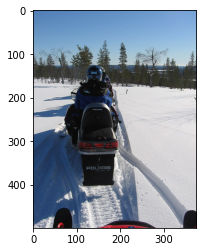

In [115]:
generate_caption(1, unq_valid_imgs.iloc[5]['image'])


Actual Caption : 
['Four small dogs play outside .', 'Four medium-sized dogs wrestle with each other on a grass field .', 'Four dogs in a grassy area .', 'A cluster of four brown dogs play in a field of brown grass .', 'Four dogs are together in the field of dry grass .']


Predicted caption : 
three dogs are playing in the grass .


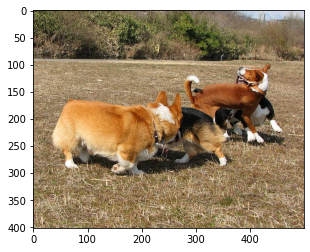

In [116]:
generate_caption(1, unq_valid_imgs.iloc[10]['image'])


Actual Caption : 
['A black man with a red mask is carrying a box .', 'A man in a domino mask carries an amplifier up a hill .', 'A man with a mask carrying a black speaker', 'A masked man in bright clothing carrying a large box .', 'Black man lifting black box is watched by black dog .']


Predicted caption : 
young boy wearing blue shirt and blue jeans is standing on the ground .


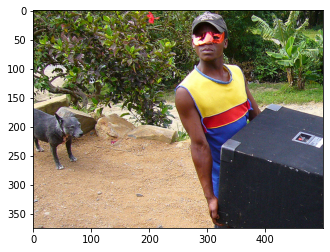

In [117]:
generate_caption(1, unq_valid_imgs.iloc[15]['image'])


Actual Caption : 
['a bird lands on a mans glove .', 'A man holds a bird .', 'A man holds a falcon on his arm .', 'Gloved man holding a bird of prey .', 'The man is wearing gloves and holding a hawk in his hands .']


Predicted caption : 
woman with brown dog is looking at man in the air .


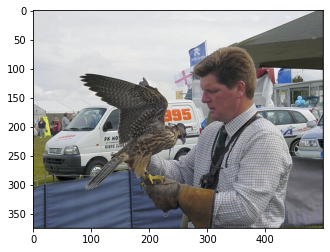

In [118]:
generate_caption(1, unq_valid_imgs.iloc[20]['image'])


Actual Caption : 
['A white dog with light brown markings has a stick in his mouth and his paws in the snow .', 'A white dog holds a stick in its mouth while it runs through snow .', 'a white dog jumps in the snow .', 'A white dog catches a stick in the snow .', 'A tan curly haired dog jumps in the snow with a stick in its mouth .']


Predicted caption : 
dog is running through snow .


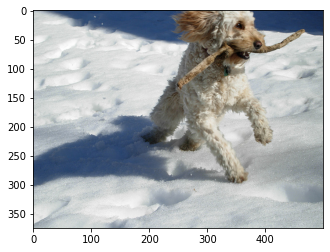

In [119]:
generate_caption(1, unq_valid_imgs.iloc[25]['image'])


Actual Caption : 
['A man in a yellow helmet climbs a cliff face , snow behind him .', 'A man is climbing up a wall with a rope', 'A man leans back while climbing a mountain tethered to a rope .', 'He is rock climbing .', 'Man with helmet rock climbing in a snowy area .']


Predicted caption : 
man is climbing up mountain .


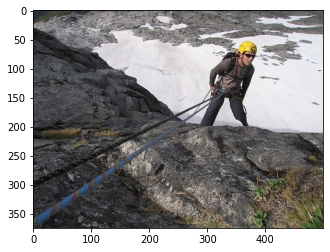

In [120]:
generate_caption(1, unq_valid_imgs.iloc[30]['image'])


Actual Caption : 
['Three men walking on a sidewalk in a city .', 'Three people are walking down the street with cars and buildings in the background .', 'Three people stand along a main road .', 'Three people walking on a sidewalk with 3 light colored cars in the background .', 'three people wearing winter clothes standing on the sidewalk near a street']


Predicted caption : 
group of people in winter clothing stand in front of street .


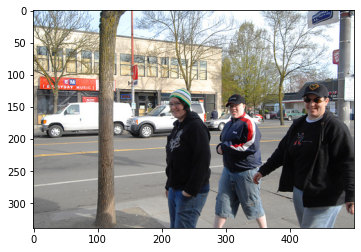

In [121]:
generate_caption(1, unq_valid_imgs.iloc[35]['image'])


Actual Caption : 
['Two dogs wearing sweaters play in a field .', 'Two dogs wearing shirts play in the green grass .', 'Two dogs wearing sweaters play in the grass .', 'The two greyhound dogs wearing sweaters are playing in the grass .', 'Two dogs play in the grass .']


Predicted caption : 
two dogs are playing with red toy .


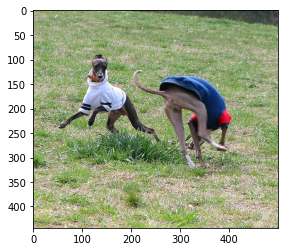

In [122]:
generate_caption(1, unq_valid_imgs.iloc[40]['image'])


Actual Caption : 
['A dog is staring at the food in the plate of a person eating .', 'A person holding a dog while they eat .', 'A person is eating a plate of pasta with a black and brown dog on his or her lap .', 'A person is eating pasta , while a dog is watching .', 'Someone in a blue and white striped sweater is eating and the dog next to them is interested in their food .']


Predicted caption : 
german shephard in blue with blue collar of blue mat on santa all floor .


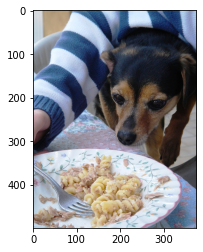

In [123]:
generate_caption(31, unq_valid_imgs.iloc[45]['image'])



< 5 번 이미지> : 
Actual Caption : 
['A caravan of snowmobile travel through the snow .', 'A pair of people in heavy winter jackets rides through the snow on a snowmobile .', 'People riding something in the snow .', 'Person on a Polaris ski mobile in the snow .', 'The man wearing a blue helmet is riding a Polaris .']


Predicted caption : 
two people are sitting on snowy mountain .
Actual Caption : 
['A caravan of snowmobile travel through the snow .', 'A pair of people in heavy winter jackets rides through the snow on a snowmobile .', 'People riding something in the snow .', 'Person on a Polaris ski mobile in the snow .', 'The man wearing a blue helmet is riding a Polaris .']


Predicted caption : 
two people are in snow at the camera at the camera while people watch from the other people .
Actual Caption : 
['A caravan of snowmobile travel through the snow .', 'A pair of people in heavy winter jackets rides through the snow on a snowmobile .', 'People riding something in the snow .', '

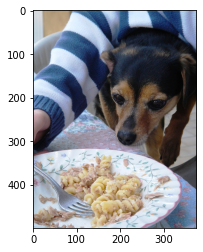

In [113]:
for j in range(1, 10):
  print("\n\n<", j*5, "번 이미지> : ")
  for i in range(1, 6):
    generate_caption(i, unq_valid_imgs.iloc[j*5]['image'])

Actual Caption : 
['A distant person is climbing up a very sheer mountain .', 'A panoramic distance view of a rock climber going up a steep mountain wall .', 'person rock climbing', 'There is a person scaling a very steep rock wall .', 'This person is climbing the side of a mountain .']


Predicted caption : 
person is climbing up rock wall .
Actual Caption : 
['A distant person is climbing up a very sheer mountain .', 'A panoramic distance view of a rock climber going up a steep mountain wall .', 'person rock climbing', 'There is a person scaling a very steep rock wall .', 'This person is climbing the side of a mountain .']


Predicted caption : 
man is climbing rock wall with his arms around him behind .
Actual Caption : 
['A distant person is climbing up a very sheer mountain .', 'A panoramic distance view of a rock climber going up a steep mountain wall .', 'person rock climbing', 'There is a person scaling a very steep rock wall .', 'This person is climbing the side of a mountain 

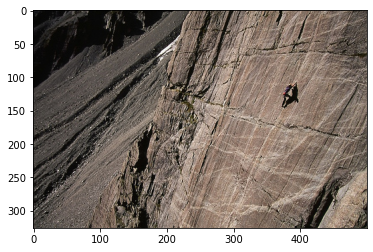

In [92]:
for i in range(1, 6):
  generate_caption(i, unq_valid_imgs.iloc[100]['image'])

Actual Caption : 
['Two black , brown and white dogs running in green grass with ears up on heads .', 'Two dogs run through a field of grass', 'Two fluffy dogs run through the grass .', 'Two look-alike dogs running in the green grass .', 'Two small dogs run through the grass .']


Predicted caption : 
dog runs through the grass .
Actual Caption : 
['Two black , brown and white dogs running in green grass with ears up on heads .', 'Two dogs run through a field of grass', 'Two fluffy dogs run through the grass .', 'Two look-alike dogs running in the green grass .', 'Two small dogs run through the grass .']


Predicted caption : 
dog runs through field .
Actual Caption : 
['Two black , brown and white dogs running in green grass with ears up on heads .', 'Two dogs run through a field of grass', 'Two fluffy dogs run through the grass .', 'Two look-alike dogs running in the green grass .', 'Two small dogs run through the grass .']


Predicted caption : 
the black and tan dogs are running th

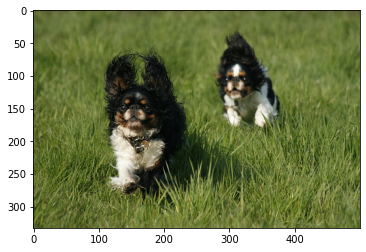

In [93]:
for i in range(1, 6):
  generate_caption(i, unq_valid_imgs.iloc[70]['image'])

** test with my images **